# Data Exploration - Phase II
Shpaner, Leonid  
Robinson, Christopher  
Luis-Estrada, Jose  

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library

/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library


In [31]:
####################################
## import the requisite libraries ##
####################################
import os
import csv
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import stats models for q-q plots and 
# baseline logistic regression
import statsmodels.api as sm

# suppress future warnings for cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# check current working directory
current_directory = os.getcwd()
current_directory

'/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library'

### Assign Paths to Folders

In [5]:
# path to the data file
data_path1 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'Final_Data_20220719/CrimesLA_Streets_with_Crimes.csv'

# path to data folder
data_path2 = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
             'Data Folder/'

# path to the image library
image_path = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime'\
          + '/Image Folder'        

In [6]:
# bring in original dataframe only for join purposes
df = pd.read_csv('/content/drive/Shareddrives/Capstone - Best Group/' \
               + 'Final_Data_20220719/df.csv', low_memory=False). \set_index('OBJECTID')

In [7]:
# read in the training .csv file to a dataframe using pandas
df_eda = pd.read_csv(data_path2 + 'eda_set.csv', low_memory=False).set_index('OBJECTID')

In [8]:
df_eda.shape

(128205, 18)

In [9]:
df.head()

,Shape,Join_Count,TARGET_FID,JOIN_FID,FullName,Type,Elevation,Surface,Status,DrivingDir,...,Status_Desc,Crm_Cd_1,Crm_Cd_2,Crm_Cd_3,Crm_Cd_4,LOCATION,Cross_Street,LAT,LON,Shape_Length
OBJECTID,,,,,,,,,,,,,,,,,,,,,
18,"(-13168057.17375, 3992141.1804500036)",1,18,33113,NaN,Alley,Unknown,Unknown,Unknown,Two Way,...,Invest Cont,624.0,NaN,NaN,NaN,600 W 20TH ST,NaN,33.7261,-118.2907,120.220887
36,"(-13180677.51995, 4031566.0669)",1,36,18064,NaN,Secondary,Surface,Paved,Unrestricted,Two Way,...,Invest Cont,624.0,NaN,NaN,NaN,MOTOR,VENICE BL,34.0205,-118.4040,15.473452
37,"(-13180677.51995, 4031566.0669)",1,36,30252,NaN,Secondary,Surface,Paved,Unrestricted,Two Way,...,Invest Cont,624.0,NaN,NaN,NaN,VENICE,MOTOR,34.0205,-118.4040,15.473452
44,"(-13160890.369035002, 4035687.0216437643)",1,43,31551,NaN,Minor,Surface,Paved,Unrestricted,Two Way,...,Invest Cont,210.0,NaN,NaN,NaN,1200 GABRIEL GARCIA MARQUEZ ST,NaN,34.0509,-118.2265,118.766240
56,"(-13165346.8195, 4030644.1469999994)",1,55,19828,NaN,Secondary,Surface,Paved,Unrestricted,Two Way,...,Invest Cont,753.0,998.0,NaN,NaN,SAN PEDRO ST,36TH ST,34.0138,-118.2663,9.731604


In [10]:
# show the columns of the dataframe for inspection
df_eda.columns

Index(['Zip_Code', 'Accuracy', 'Crime_Cost', 'StreetOID', 'DR_NO', 'TIME_OCC',
       'AREA', 'Rpt_Dist_No', 'Part_1_2', 'Vict_Age', 'Premis_Cd',
       'Weapon_Used_Cd', 'Days_Disclosure', 'Street_Type', 'Gender',
       'Crime_Code', 'age_bin', 'crime_sev'],
      dtype='object')

In [11]:
# merge df_eda with df on df['Type']
# eda_merge = df_eda.merge(df)
# df_eda = eda_merge.copy()

In [67]:
df.columns

Index(['Shape', 'Join_Count', 'TARGET_FID', 'JOIN_FID', 'FullName', 'Type',
       'Elevation', 'Surface', 'Status', 'DrivingDir', 'From_L', 'From_R',
       'To_L', 'To_R', 'Parity_L', 'Parity_R', 'StPreDir', 'StPreMod',
       'StPreType', 'StArticle', 'StName', 'StPostType', 'StPostDir',
       'StPostMod', 'Zip_L', 'Zip_R', 'LCity_L', 'LCity_R', 'NameCat_L',
       'NameCat_R', 'Accuracy', 'Jurisdiction', 'Source', 'SourceID',
       'UpdateDate', 'MSAG_LCity', 'MSAG_RCity', 'MSAG_LESN', 'MSAG_RESN',
       'Crime_Cost', 'StreetOID', 'Field1', 'DR_NO', 'Date_Rptd', 'DATE_OCC',
       'TIME_OCC', 'AREA', 'AREA_NAME', 'Rpt_Dist_No', 'Part_1_2', 'Crm_Cd',
       'Crm_Cd_Desc', 'Mocodes', 'Vict_Age', 'Vict_Sex', 'Vict_Descent',
       'Premis_Cd', 'Premis_Desc', 'Weapon_Used_Cd', 'Weapon_Desc', 'Status_1',
       'Status_Desc', 'Crm_Cd_1', 'Crm_Cd_2', 'Crm_Cd_3', 'Crm_Cd_4',
       'LOCATION', 'Cross_Street', 'LAT', 'LON', 'Shape_Length'],
      dtype='object')

In [66]:
df_eda = df_eda.join(df['Status_Desc'], how='left', lsuffix='left', rsuffix='right')
df_eda = df_eda.join(df['Type'], how='left', lsuffix='left', rsuffix='right')
df_eda = df_eda.join(df['Vict_Sex'], how='left', lsuffix='left', rsuffix='right')
df_eda.head()

,Zip_Code,Accuracy,Crime_Cost,StreetOID,DR_NO,TIME_OCC,AREA,Rpt_Dist_No,Part_1_2,Vict_Age,...,Status_Descleft,Typeleft,Status_Descright,Typeright,Vict_Sexleft,Status_Descleft,Typeleft,Status_Descright,Typeright,Vict_Sexright
OBJECTID,,,,,,,,,,,,,,,,,,,,,
69772,"90,024.00",50.00,2.00,27815,"210,814,900.00",750.00,8.00,833.00,2.00,40.00,...,Invest Cont,Primary,Invest Cont,Primary,F,Invest Cont,Primary,Invest Cont,Primary,F
131641,"90,037.00",50.00,3.00,51117,"210,313,311.00","1,100.00",3.00,397.00,1.00,32.00,...,Invest Cont,Minor,Invest Cont,Minor,M,Invest Cont,Minor,Invest Cont,Minor,M
143866,"90,016.00",50.00,1.00,55526,"200,705,585.00","1,420.00",7.00,785.00,1.00,46.00,...,Adult Other,Primary,Adult Other,Primary,M,Adult Other,Primary,Adult Other,Primary,M
189323,"90,003.00",50.00,0.00,72325,"221,213,641.00",910.00,12.00,"1,268.00",2.00,25.00,...,Invest Cont,Minor,Invest Cont,Minor,F,Invest Cont,Minor,Invest Cont,Minor,F
89956,"91,331.00",50.00,2.00,35427,"221,606,939.00","1,625.00",16.00,"1,612.00",2.00,63.00,...,Invest Cont,Secondary,Invest Cont,Secondary,M,Invest Cont,Secondary,Invest Cont,Secondary,M


In [13]:
# re-inspect the shape of the dataframe. This is also done on EDA file.
df_eda.shape

(128205, 20)

## Bar Plot of Age Range

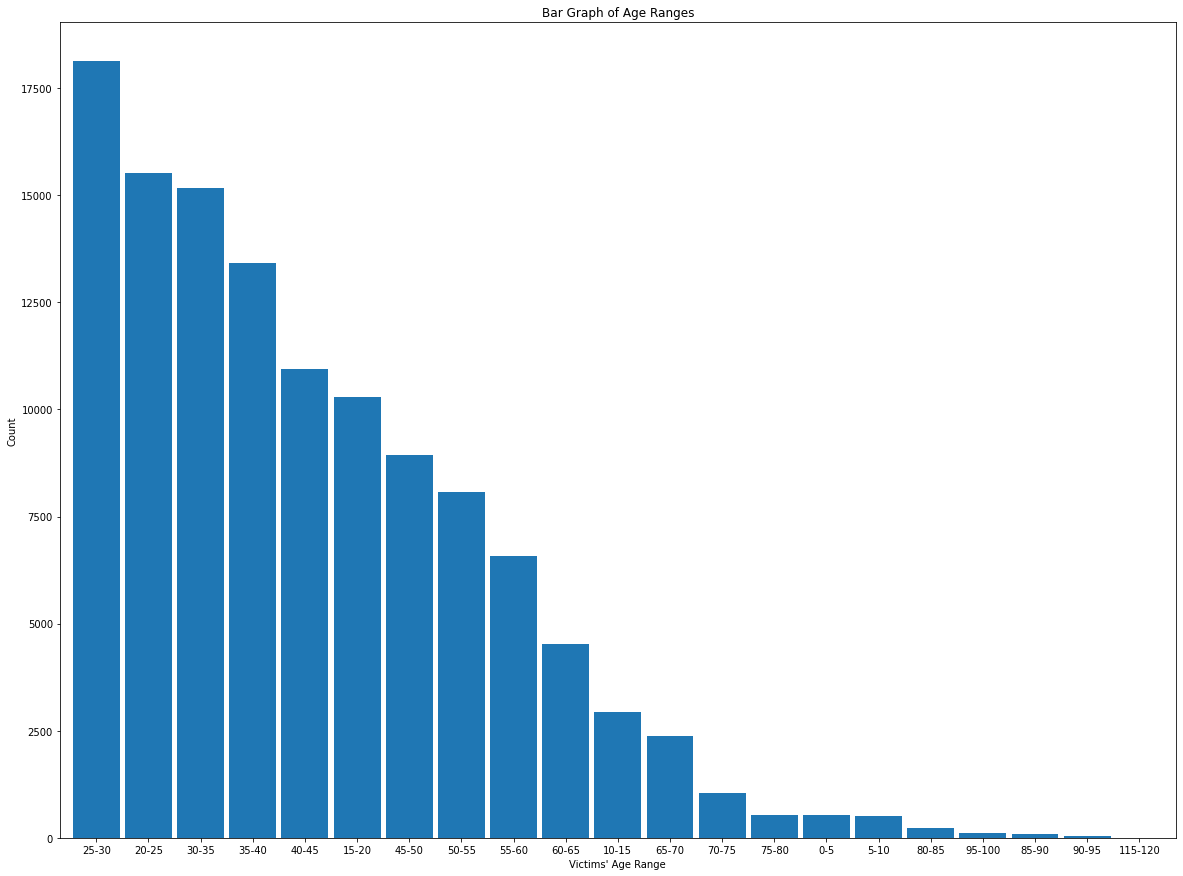

In [14]:
# this bar_plot library was created as a bar_plot.py file during the EDA Phase I
# stage; it can be acccessed in that respective notebook
from bar_plot import bar_plot
bar_plot(20,15, df_eda, False, 'bar', 'Bar Graph of Age Ranges', 0, 
         "Victims' Age Range", 'Count', 'age_bin', 100)
plt.savefig(image_path + '/age_range_bargraph.png', bbox_inches = 'tight')

## Contingency Table

In [15]:
def cont_table(df, col1, lev1, col2, lev2, new):
  crime_less = df.loc[df[col1]==lev1].groupby([col2])[[col1]].count()
  crime_less.rename(columns = {col1:lev1}, inplace=True)
  crime_more = df.loc[df[col1]==lev2].groupby([col2])[[col1]].count()
  crime_more.rename(columns={col1:lev2}, inplace=True)
  crime_res_comb = pd.concat([crime_less, crime_more], axis=1)

  # sum row totals
  crime_res_comb['Total']=crime_res_comb.sum(axis=1)
  crime_res_comb.loc['Total']=crime_res_comb.sum(numeric_only=True, axis=0)
  # get % total of each row
  crime_res_comb['% More Serious']=round((crime_res_comb[lev2] / 
  (crime_res_comb[lev2]+crime_res_comb[lev1]))*100, 2)
  crime_res_comb[lev2]=crime_res_comb[lev2].fillna(0)
  crime_res_comb['% More Serious']=crime_res_comb['% More Serious'].fillna(0)
  df.rename_axis(new)
  # crime_res_comb.set_index('new_index_name')
  
  return crime_res_comb.style.format("{:,.0f}")

### Contingency Table - Crime Severity by Age Groups

In [16]:
age_table = cont_table(df_eda, 'crime_sev', 'Less Serious', 'age_bin', 
                       'More Serious', 'N').data
age_table

,Less Serious,More Serious,Total,% More Serious
age_bin,,,,
0-5,177.0,348.0,525.0,66.29
10-15,1593.0,1349.0,2942.0,45.85
15-20,4375.0,5924.0,10299.0,57.52
20-25,6728.0,8802.0,15530.0,56.68
25-30,7693.0,10437.0,18130.0,57.57
30-35,6787.0,8391.0,15178.0,55.28
35-40,5948.0,7476.0,13424.0,55.69
40-45,4695.0,6244.0,10939.0,57.08
45-50,4070.0,4876.0,8946.0,54.50


## Summary Statistics

In [58]:
def summ_stats(df, var1, var2):
    print("\033[1m"+'Summary Statistics by Age'+"\033[1m")
    pd.options.display.float_format = '{:,.2f}'.format
    summ_stats = df.groupby(var1)[var2].agg(['mean', 'median', 'std', 'min', 'max'])
    summ_stats.loc['Total'] = summ_stats.sum(numeric_only=True, axis=0)
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = summ_stats.rename(columns = column_rename)
    return dfsummary

### Status Description by Age

In [60]:
summ_stats(df_eda, 'Status_Desc', 'Vict_Age')

Summary Statistics by Age


,Mean,Median,Standard Deviation,Minimum,Maximum
Status_Desc,,,,,
Adult Arrest,32.95,32.00,17.80,0.00,99.00
Adult Other,35.67,34.00,15.21,0.00,99.00
Invest Cont,34.64,33.00,17.02,0.00,120.00
Juv Arrest,26.17,23.00,16.52,0.00,81.00
Juv Other,24.10,17.00,16.35,0.00,76.00
Total,153.53,139.00,82.90,0.00,475.00


### Victim Sex by Age

In [64]:
summ_stats(df_eda, 'Vict_Sex', 'Vict_Age')

Summary Statistics by Age


,Mean,Median,Standard Deviation,Minimum,Maximum
Vict_Sex,,,,,
F,34.44,32.00,15.21,0.00,99.00
H,35.11,34.00,26.93,0.00,68.00
M,36.32,35.00,16.49,0.00,99.00
X,5.38,0.00,12.21,0.00,86.00
Total,111.26,101.00,70.84,0.00,352.00


In [62]:
df_eda

,Zip_Code,Accuracy,Crime_Cost,StreetOID,DR_NO,TIME_OCC,AREA,Rpt_Dist_No,Part_1_2,Vict_Age,Premis_Cd,Weapon_Used_Cd,Days_Disclosure,Street_Type,Gender,Crime_Code,age_bin,crime_sev,Status_Desc,Type
OBJECTID,,,,,,,,,,,,,,,,,,,,
69772,"90,024.00",50.00,2.00,27815,"210,814,900.00",750.00,8.00,833.00,2.00,40.00,102.00,400.00,0,7,1,0,35-40,Less Serious,Invest Cont,Primary
131641,"90,037.00",50.00,3.00,51117,"210,313,311.00","1,100.00",3.00,397.00,1.00,32.00,101.00,106.00,0,8,2,0,30-35,Less Serious,Invest Cont,Minor
143866,"90,016.00",50.00,1.00,55526,"200,705,585.00","1,420.00",7.00,785.00,1.00,46.00,101.00,102.00,0,7,2,1,45-50,More Serious,Adult Other,Primary
189323,"90,003.00",50.00,0.00,72325,"221,213,641.00",910.00,12.00,"1,268.00",2.00,25.00,102.00,400.00,0,8,1,0,20-25,Less Serious,Invest Cont,Minor
89956,"91,331.00",50.00,2.00,35427,"221,606,939.00","1,625.00",16.00,"1,612.00",2.00,63.00,108.00,400.00,0,6,2,0,60-65,Less Serious,Invest Cont,Secondary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231501,"91,342.00",50.00,0.00,87709,"211,909,216.00",40.00,19.00,"1,901.00",1.00,40.00,101.00,500.00,0,7,2,1,35-40,More Serious,Adult Arrest,Primary
148387,"90,003.00",50.00,22.00,57124,"201,319,927.00","1,610.00",13.00,"1,383.00",1.00,0.00,101.00,110.00,0,7,2,1,NaN,More Serious,Invest Cont,Primary
81897,"90,028.00",50.00,7.00,32379,"210,606,914.00",5.00,6.00,635.00,1.00,27.00,101.00,109.00,0,6,2,1,25-30,More Serious,Invest Cont,Secondary


In [61]:
summ_stats(df_eda, 'Vict', 'Vict_Age')

Summary Statistics by Age


KeyError: ignored

## Stacked Bar Plots

In [17]:
def stacked_plot (x, y, df, col, truth, condition, kind, xlabel1, ylabel1, 
               xlabel2, ylabel2):
  fig = plt.figure(figsize=(x, y))
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212)
  fig.tight_layout(pad=10)
  fig.suptitle('Absolute Distributions vs. Normalized Distributions')

  crosstabdest = pd.crosstab(df[col], df[truth])\
                .sort_values(by=[condition], ascending=False)
  crosstabdestnorm = crosstabdest.div(crosstabdest.sum(1), axis = 0)

  plotdest = crosstabdest.plot(kind=kind, stacked=True, 
                              title = 'Destination and Target', xlabel=xlabel1, 
                              ylabel=ylabel1, ax = ax1, color=['#00BFC4', 
                                                              '#F8766D'], rot=0)
  plotdestnorm = crosstabdestnorm.plot(kind=kind, stacked=True, 
                                      title = 'Destination and Target Normalized',
                                      xlabel=xlabel2, ylabel=ylabel2,
                                      ax = ax2, color = ['#00BFC4', '#F8766D'], 
                                      rot=0)

### Crime Severity by Age Group

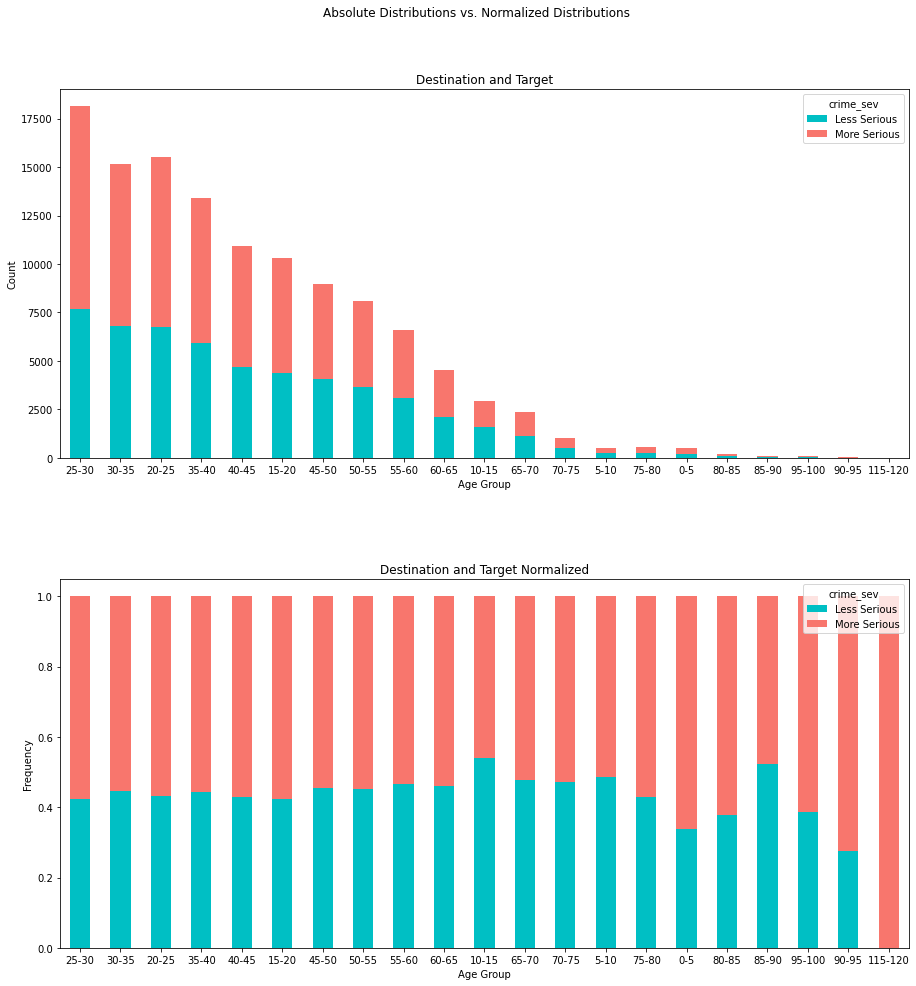

In [18]:
stacked_plot(15, 15, df_eda, 'age_bin', 'crime_sev', 'Less Serious', 'bar', 
            'Age Group', 'Count', 'Age Group', 'Frequency')
plt.savefig(image_path + '/age_crime_bargraph.png', bbox_inches = 'tight')

### Status Description by Crime Severity

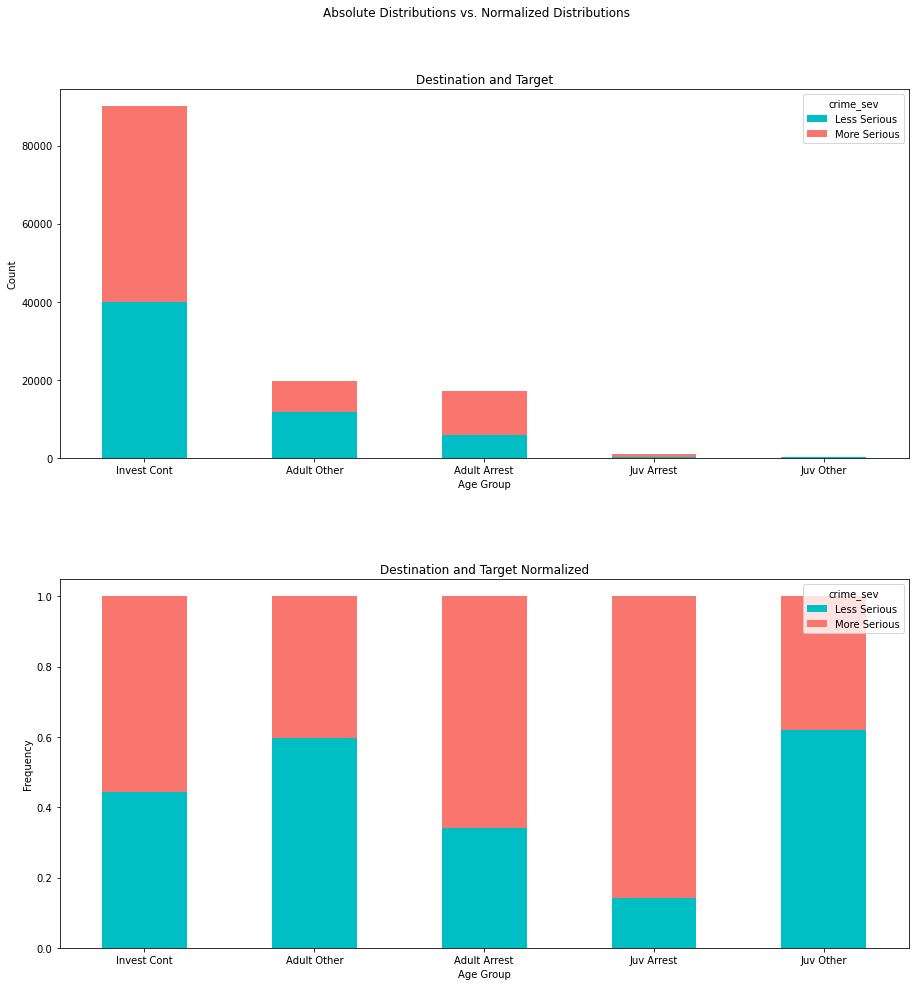

In [19]:
stacked_plot(15, 15, df_eda, 'Status_Desc', 'crime_sev', 'Less Serious', 'bar', 
            'Age Group', 'Count', 'Age Group', 'Frequency')

### Crime Severity by Street Type

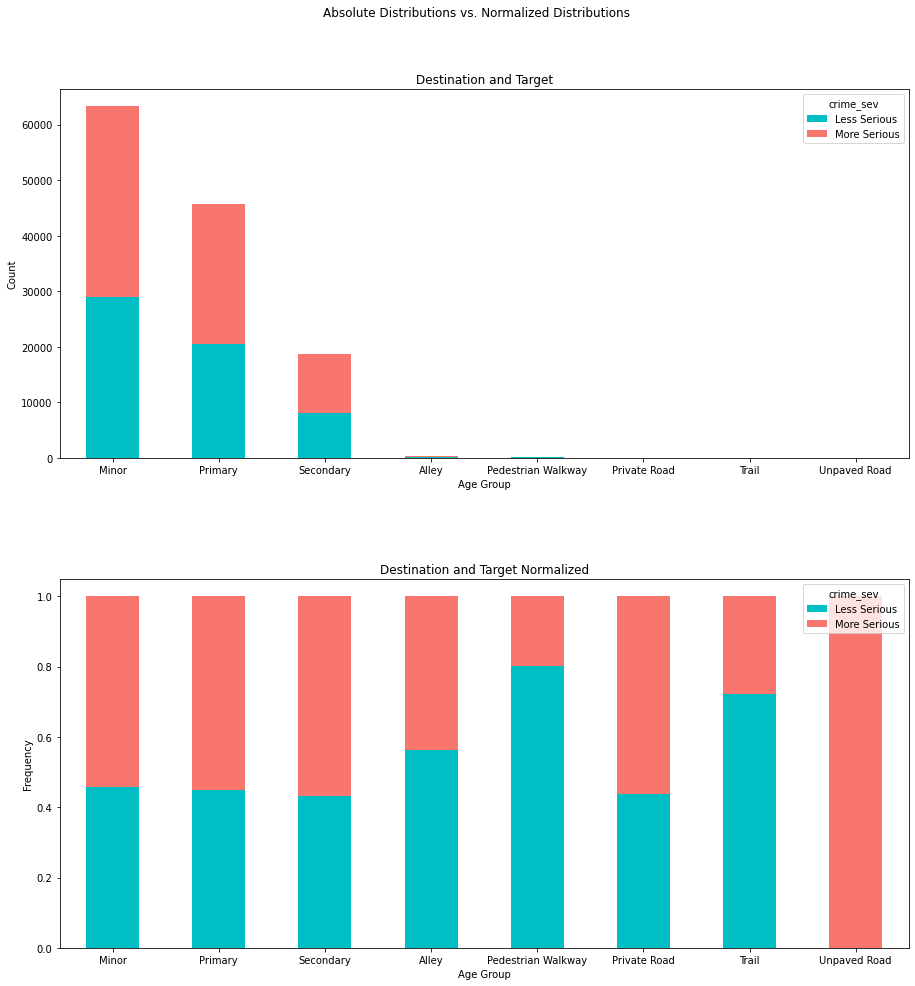

In [20]:
stacked_plot(15, 15, df_eda, 'Type', 'crime_sev', 'Less Serious', 'bar', 
            'Age Group', 'Count', 'Age Group', 'Frequency')

In [48]:
# x = df_eda[['Zip_Code', 'Accuracy', 'Crime_Cost', 'StreetOID', 'DR_NO', 'TIME_OCC', 'AREA', 'Rpt_Dist_No', 'Part_1_2', 'Vict_Age',	'Premis_Cd',	'Weapon_Used_Cd',	'Days_Disclosure',	'Street_Type',	'Gender']]

In [50]:
# y = df_eda['Crime_Code']